# Analyze Maricopa County, Arizona  Biodiversity Intactness Index (BII) changes from 2017-2020

Author: Hazel Vaquero

## About 

In this notebook, I analyzed the changes observed in the Biodiversity Intactness Index (BII) in Maricopa County, Phoenix, Arizona from 2017 to 2020. In 2021, Maricopa County was reported as the fastest-growing county in the United States since 2001. It is the 4th largest county in terms of population. Urbananization is one of the greatest threats to biodiversity, and urban land use is expected to increase in the following [years.](https://www.creaf.cat/global-change/urbanization-and-biodiversity#:~:text=Of%20all%20of%20the%20environmental,become%20dominated%20by%20anthropic%20habitats.) Understanding the impacts of urbanization on biodiversity is important for the perservation of the natural systems and services they provide.  


This notebook seeks to analyze the impact of the rapid urban expansion in Maricopa County. 

If you would like more information or acess the datasets needed for this notebook please find more information at the following repository link:
https://github.com/hazelvaq/Maricopa-Arizona-Changes-in-Biodiversity-Intactness-Index-.git 

## About the Datasets

In this notebook two different datasets are used:

**1. BII Data** 

The first dataset is from the [Planetary Computer Impact Observatory](https://planetarycomputer.microsoft.com/dataset/io-biodiversity). This dataset estimates terrestrial Biodiversity Intactness as a 100-meter gridded maps for the years 2017-2020. Biodiversity intactness is an estimated combination of two metrics:
- Abundance
- Compositional Similarity: how similar the composition of species is to an intact baseline

It builds on past studies using the [PREDICTS](https://onlinelibrary.wiley.com/doi/full/10.1002/ece3.2579) database of spatially referenced obeservations of biodiversity across 32,000 sites from over 750 studies.


The collection we will be working with is `io-biodiversity`. 

**2. Phoenix Subdivison** 

The second dataste is from the [United Census Bureau](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions). This data has been downloaded as a shapefile and has 19 columns. It contains the county names, land area and water area to name a few. Arizona county subdivision will be used for this notebook.




<ins> Data Citations <ins> :
    
Microsoft Open Source, Matt McFarland, Rob Emanuele, Dan Morris, & Tom Augspurger. (2022). microsoft/PlanetaryComputer: October 2022 (2022.10.28). Zenodo. https://doi.org/10.5281/zenodo.7261897
    
U.S. Census Bureau. (2022). 2022 TIGER/Line® Shapefiles: County Subdivisions. Retrieved December 5, from https://www.census.gov/cgi-bin/geo/shapefiles/index.phpyear=2022&layergroup=County+Subdivisions




### Import Libraries 

In [1]:
# Import Libraries
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # for creating legends

from shapely.geometry import Polygon

# Used to access STAC catalogs
from pystac_client import Client
# Used to sign items from the MPC STAC catalog
import planetary_computer

# other libraries for nice outputs
from IPython.display import Image

# Package to work with web-tiles for background maps
import contextily as ctx

### Catalog Search

We can narrow the search within the `catalog` by specifying our
- Time range: 2017 - 2020
- Area of Interest: `[-112.826843, 32.974108, -111.184387, 33.863574]`
- Collection name: `io-biodiversity`

In [2]:
# Data Import: BII data

## Acess Planatery Computer Catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

## Catalog Search
# Set temporal range
time_range = "2017/2020"
# Bonding box of Phoenix subdivision
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]
# catalog search
search = catalog.search(
    collections=['io-biodiversity'],
    bbox=bbox,
    datetime = time_range
)

Lets view the items in the catalog search and select the first item!

In [3]:
# Get items found in catalog search
items = search.item_collection()

# There are 4 items in our time range and area of interest
items

id: bii_2020_34.74464974521749_-115.38597824385106_cog
"bbox: [-115.3859782, 27.565314, -108.2066425, 34.7446497]"
datetime: None
proj:epsg: 4326
"proj:shape: [7992, 7992]"
end_datetime: 2020-12-31T23:59:59Z
"proj:transform: [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0]"
start_datetime: 2020-01-01T00:00:00Z
https://stac-extensions.github.io/projection/v1.0.0/schema.json
https://stac-extensions.github.io/raster/v1.1.0/schema.json
https://stac-extensions.github.io/version/v1.1.0/schema.json


We are interested in finding the BII diversity from 2017 to 2020. So we need to select both datasets. In our previous inspection of `items` we determined 2020 to be the first value of `items`. Our 2017 is our 4th value. 

In [4]:
# Select our 2017 item
item_2017 = items[3]

# Select our 2020 item
item_2020 = items[0]

Now we can view the item assets keys. Our assets of interest are:

- `data`: which contains the data we are interested in
- `rendered_preview`: a preview of our raster imagery

In [5]:
# Let's view our keys in assets
for key in item_2020.assets.keys():
    print(key, '--', item_2020.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


Let's view our rendered preview.

In [6]:
# plot 2017 rendered preview
Image(url=item_2017.assets['rendered_preview'].href, width=500)

In [7]:
# plot 2020 rendered preview
Image(url=item_2020.assets['rendered_preview'].href, width=500)

### Import Data

Now we can select our `data` from the catelog for our analysis  

#### Data Import: Maricopa County BII data

In [8]:
# 2017 Maricopa County data
bi_2017 = rioxr.open_rasterio(item_2017.assets['data'].href)
bi_2017

# 2020 Maricopa County data
bi_2020 = rioxr.open_rasterio(item_2020.assets['data'].href)
bi_2020

<xarray.DataArray (band: 1, y: 7992, x: 7992)>
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57 27.57
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

#### Data Import: Arizona Counties shapefile 

In [9]:
# Data Import: Arizona counties shapefile
arizona_sub = gpd.read_file('data/tl_2022_04_cousub/tl_2022_04_cousub.shp')

# Data Import: U.S. states shapefile
us_states = gpd.read_file('data/states_shapefile/States_shapefile.shp')

## Prepare Data

Let's take a few steps to clean up our data for analysis

In [11]:
# Lets make this lower case 
arizona_sub.columns = arizona_sub.columns.str.lower()

# Filter to Phoenix subdivision
phoenix = arizona_sub[arizona_sub.name =='Phoenix']

# Let's view our results 
phoenix

,statefp,countyfp,cousubfp,cousubns,geoid,name,namelsad,lsad,classfp,mtfcc,cnectafp,nectafp,nctadvfp,funcstat,aland,awater,intptlat,intptlon,geometry
10,04,013,92601,01934968,0401392601,Phoenix,Phoenix CCD,22,Z5,G4040,NaN,NaN,NaN,S,2806478817,9471127,+33.5211331,-112.0284405,"POLYGON ((-112.47014 33.55996, -112.47011 33.5..."


#### Phoenix subdivision geographical context

For geographical context, below is a map of the Phoenix subdivision with relation to Arizona.

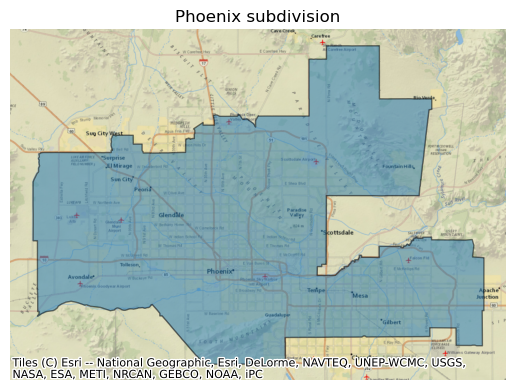

In [12]:
# Map of Phoenix subdivision with appropraite geographical context

fig, ax = plt.subplots()

(phoenix.to_crs(epsg=3857).plot(ax=ax, figsize = (20,20), alpha = 0.5, edgecolor = "k"))

ctx.add_basemap(ax=ax, source = ctx.providers.Esri.NatGeoWorldMap)

ax.set_title("Phoenix subdivision")
ax.set_axis_off()

**Cropping**

Now we can crop our bii raster data to our `phoenix` shapefile.

In [13]:
# reproject phoenix to stack crs
phoenix = phoenix.to_crs(bi_2017.rio.crs)

print("CRS match:",phoenix.crs == bi_2017.rio.crs)

CRS match: True


In [14]:
# Lets crop the county data to the both rasters

# Clip 2017 BII raster
bi_2017 = bi_2017.rio.clip(phoenix["geometry"])

# Clip 2020 BII raster
bi_2020 = bi_2020.rio.clip(phoenix["geometry"])

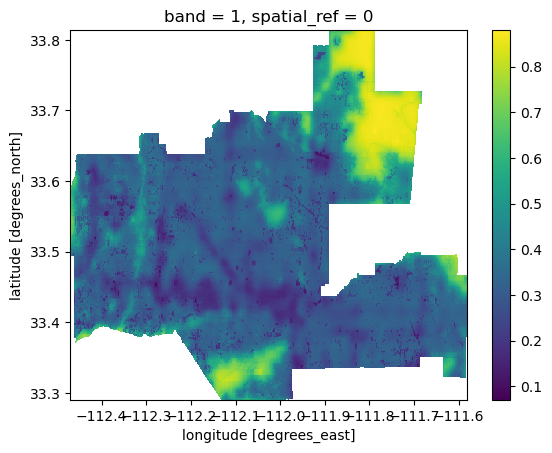

In [15]:
# View 2017 results 
bi_2017.plot()

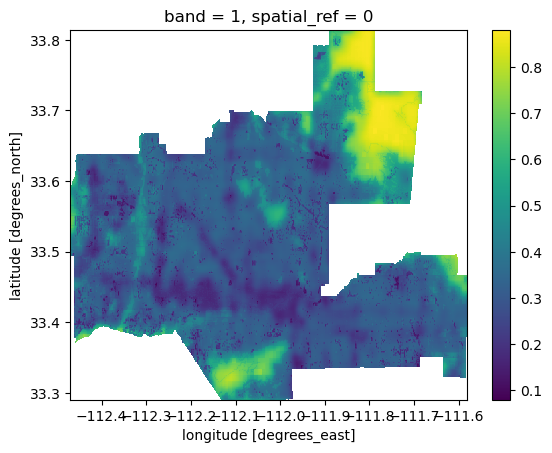

In [16]:
# View 2020 BII
bi_2020.plot()

### Percentage of Area and raster manipulation

We are interested in identifying areas in the Phoneix subdivision that saw a BII of at least 0.75 for 2017 and 2020. This can be done by the following method: 

In [17]:
# Find areas in 2017 that are greater than 0.75
area_2017 = bi_2017 >= 0.75

# Convert boolean values as 1 and 0's
area_2017 = area_2017.astype(int)

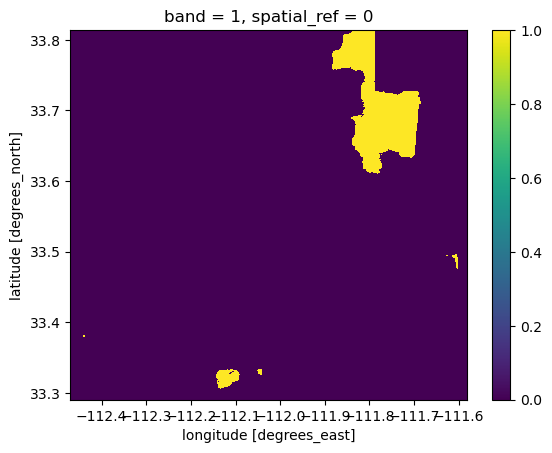

In [18]:
# View results
area_2017.plot()

In [19]:
# Find areas in 2020 that are geater than 0.75
area_2020 = bi_2020 >= 0.75

# Convert boolean values as 1 and 0's
area_2020 = area_2020.astype(int)

### Percentage of Area section

We are interested in finding the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017 and 2020. 

In [20]:
# Calulate the percent by taking the sum values as 1 / total count - 2017
percent_2017 = area_2017.sum().item() / area_2017.count().item() * 100

# Calulate the percent by taking the sum values as 1 / total count - 2020
percent_2020 = area_2020.sum().item() / area_2020.count().item() * 100

# Create a general line of text 
text = "Percentage of area with a BII of at least 0.75 in"

# Print percent area results for 2017
print(text, "2017:", round(percent_2017,4), "%")

# Print percent area results for 2020
print(text, "2020:", round(percent_2020,4), "%")

Percentage of area with a BII of at least 0.75 in 2017: 4.1813 %
Percentage of area with a BII of at least 0.75 in 2020: 3.8093 %


## Visualization of area in 2017 lost by 2020

### Preparation

In [21]:
# Calculate the difference between bii 2017 and bii2020
bi_difference = area_2017 - area_2020

In [22]:
# Find just the 1 values
bi_difference = bi_difference == 1  

# Convert our results back to boolean values (0,1)
bi_difference = bi_difference.astype(int)

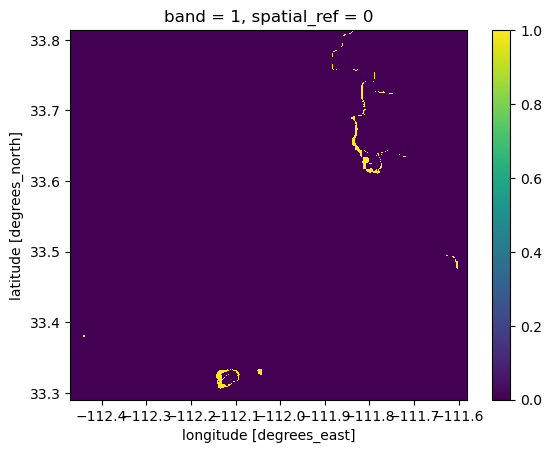

In [23]:
# View our results
bi_difference.plot()

Let's change the color schale by setting our `1` values to `red` and `0` to `none`

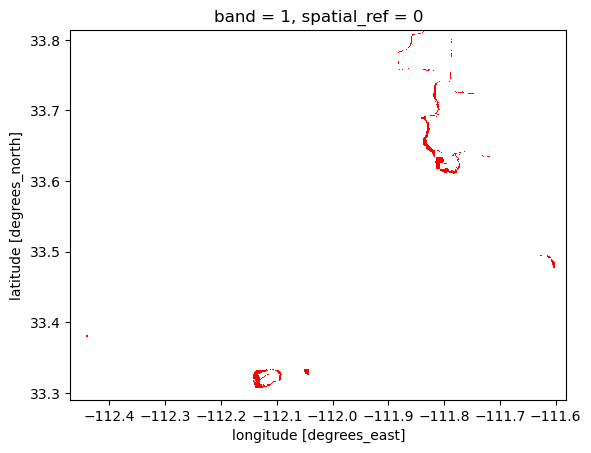

In [24]:
# Create a custom colormap with two distinct colors
colors = ['none', 'red']  # Specify colors for your two categories
cmap = plt.cm.colors.ListedColormap(colors)

# Plot to view results
bi_difference.plot(cmap=cmap, add_colorbar = False) 

### Map Creation
Visualization showing the area with BII>=0.75 in 2017 that was lost by 2020

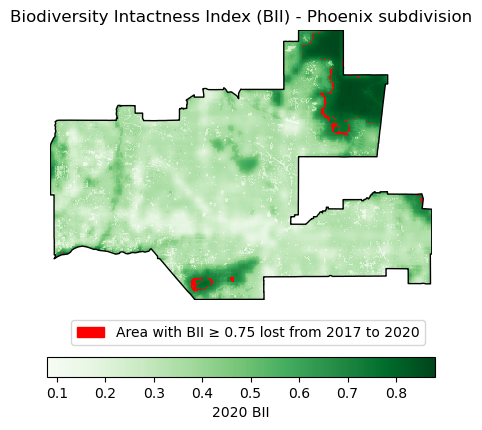

<Figure size 640x480 with 0 Axes>

In [25]:
fig, ax = plt.subplots(figsize = (5,5))

# Remove axis
ax.axis("off")

# ---------------------- BII 2017 map ------------------------------------------------
bi_2020.plot(ax=ax, cmap='Greens',
             cbar_kwargs={"location": "bottom", 'label': "2020 BII"},)
# ----- Area with BII ≥ 0.75 lost from 2017 to 2020 ----------------------------------  
bi_difference.plot(ax=ax ,cmap=cmap, add_colorbar = False)
bi_patches = mpatches.Patch(color = "red",
                           label = "Area with BII ≥ 0.75 lost from 2017 to 2020")

# --------------------- Add Phoenix base map ----------------------------------------
phoenix.plot(ax = ax,color = "none", linewidth = 1)

# ----Legend -------------------------------------------------------------------------
ax.legend(handles = [bi_patches], bbox_to_anchor=(1,-.05))
ax.set_title("Biodiversity Intactness Index (BII) - Phoenix subdivision")

plt.show()
plt.savefig('bii_phoenix.png',bbox_inches = 'tight',dpi = 50)